In [1]:
import os, sys
from pathlib import Path
import time

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import xarray as xr
import xesmf as xe

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

/home/jace/miniconda3/envs/climate-downscaling/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
INPUT_PATH = Path("../../data/02-processed")
RESOLUTION = 0.02 # 2 km
CROP_ALLOWANCE_DEG = 13*RESOLUTION
CITY_NAME = 'Dagupan'
YEAR = 2007

## Read aligned file

In [3]:
input_ds = xr.open_dataset(INPUT_PATH / 'input' / f'all_vars_regridded_{CITY_NAME.lower()}.nc')
input_ds

<xarray.Dataset>
Dimensions:      (time: 365, lat: 25, lon: 27, band: 1)
Coordinates:
  * time         (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * lon          (lon) float64 120.0 120.0 120.0 120.1 ... 120.5 120.5 120.5
  * lat          (lat) float64 15.91 15.93 15.95 15.97 ... 16.35 16.37 16.39
  * band         (band) int32 1
    spatial_ref  int32 ...
Data variables: (12/26)
    u10_mean     (time, lat, lon) float32 ...
    v10_mean     (time, lat, lon) float32 ...
    d2m_mean     (time, lat, lon) float32 ...
    t2m_mean     (time, lat, lon) float32 ...
    sp_mean      (time, lat, lon) float32 ...
    tp_mean      (time, lat, lon) float32 ...
    ...           ...
    tcc_max      (time, lat, lon) float32 ...
    tmin         (time, lat, lon) float32 ...
    tmax         (time, lat, lon) float32 ...
    precip       (time, lat, lon) float32 ...
    ndvi         (time, band, lat, lon) float32 ...
    elevation    (band, lat, lon) float32 ...
Attributes:
    regrid_method:  bilinear

### Interpolate across lon and lat

In [4]:
input_regridded_ds = input_ds.copy()

In [5]:
mask = xr.where(input_ds['elevation']>0,1,0)
for variable in [v for v in list(input_ds.variables.keys()) if v not in ['lon','lat','time','spatial_ref','band']] :
    input_regridded_ds[variable] = input_regridded_ds[variable].interpolate_na(dim="lon", method='slinear')\
                                                                .interpolate_na(dim="lat", method='slinear')
    # Apply mask
    input_regridded_ds[variable] = input_regridded_ds[variable]/mask
    # Inf as nan
    input_regridded_ds = input_regridded_ds.where(np.isfinite(input_regridded_ds), np.nan)
input_regridded_ds

<xarray.Dataset>
Dimensions:      (time: 365, lat: 25, lon: 27, band: 1)
Coordinates:
  * time         (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * lon          (lon) float64 120.0 120.0 120.0 120.1 ... 120.5 120.5 120.5
  * lat          (lat) float64 15.91 15.93 15.95 15.97 ... 16.35 16.37 16.39
  * band         (band) int32 1
    spatial_ref  int32 0
Data variables: (12/26)
    u10_mean     (time, lat, lon, band) float64 nan nan nan nan ... nan nan nan
    v10_mean     (time, lat, lon, band) float64 nan nan nan nan ... nan nan nan
    d2m_mean     (time, lat, lon, band) float64 nan nan nan nan ... nan nan nan
    t2m_mean     (time, lat, lon, band) float64 nan nan nan nan ... nan nan nan
    sp_mean      (time, lat, lon, band) float64 nan nan nan nan ... nan nan nan
    tp_mean      (time, lat, lon, band) float64 nan nan nan nan ... nan nan nan
    ...           ...
    tcc_max      (time, lat, lon, band) float64 nan nan nan nan ... nan nan nan
    tmin         (time, lat, lon, band) float64 nan nan nan nan ... nan nan nan
    tmax         (time, lat, lon, band) float64 nan nan nan nan ... nan nan nan
    precip       (time, lat, lon, band) float64 nan nan nan nan ... nan nan nan
    ndvi         (time, band, lat, lon) float64 nan nan nan nan ... nan nan nan
    elevation    (band, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    regrid_method:  bilinear

## Save interpolated file

In [ ]:
input_regridded_ds.to_netcdf(INPUT_PATH / 'input' / f"all_vars_regridded_interpolated_{CITY_NAME.lower()}.nc", engine="scipy")

## Plot data to check interpolation

In [19]:
#raw
ds_list = []
INPUT_RAW_DIR = Path("../../data/01-raw/")
era_ds = xr.open_dataset(INPUT_RAW_DIR/'era5'/f'ERA5_PH_{YEAR}04.nc')
chirts_tmin_ds = xr.open_dataset(INPUT_RAW_DIR/'chirts'/f'CHIRTS_Tmin_PH_{YEAR}.nc')
chirts_tmax_ds = xr.open_dataset(INPUT_RAW_DIR/'chirts'/f'CHIRTS_Tmax_PH_{YEAR}.nc')
chirps_ds = xr.open_dataset(INPUT_RAW_DIR/'chirps'/f'CHIRPS_PH_{YEAR}.nc')
ndvi_ds = xr.open_dataset(INPUT_RAW_DIR/'ndvi'/f'NDVI_PH_{YEAR}04.nc')
strm_ds = xr.open_dataset(INPUT_RAW_DIR/ 'dem' / f'SRTM_{CITY_NAME}.tiff')
ds_list = [era_ds,chirts_tmin_ds,chirts_tmax_ds,chirps_ds,ndvi_ds,strm_ds]

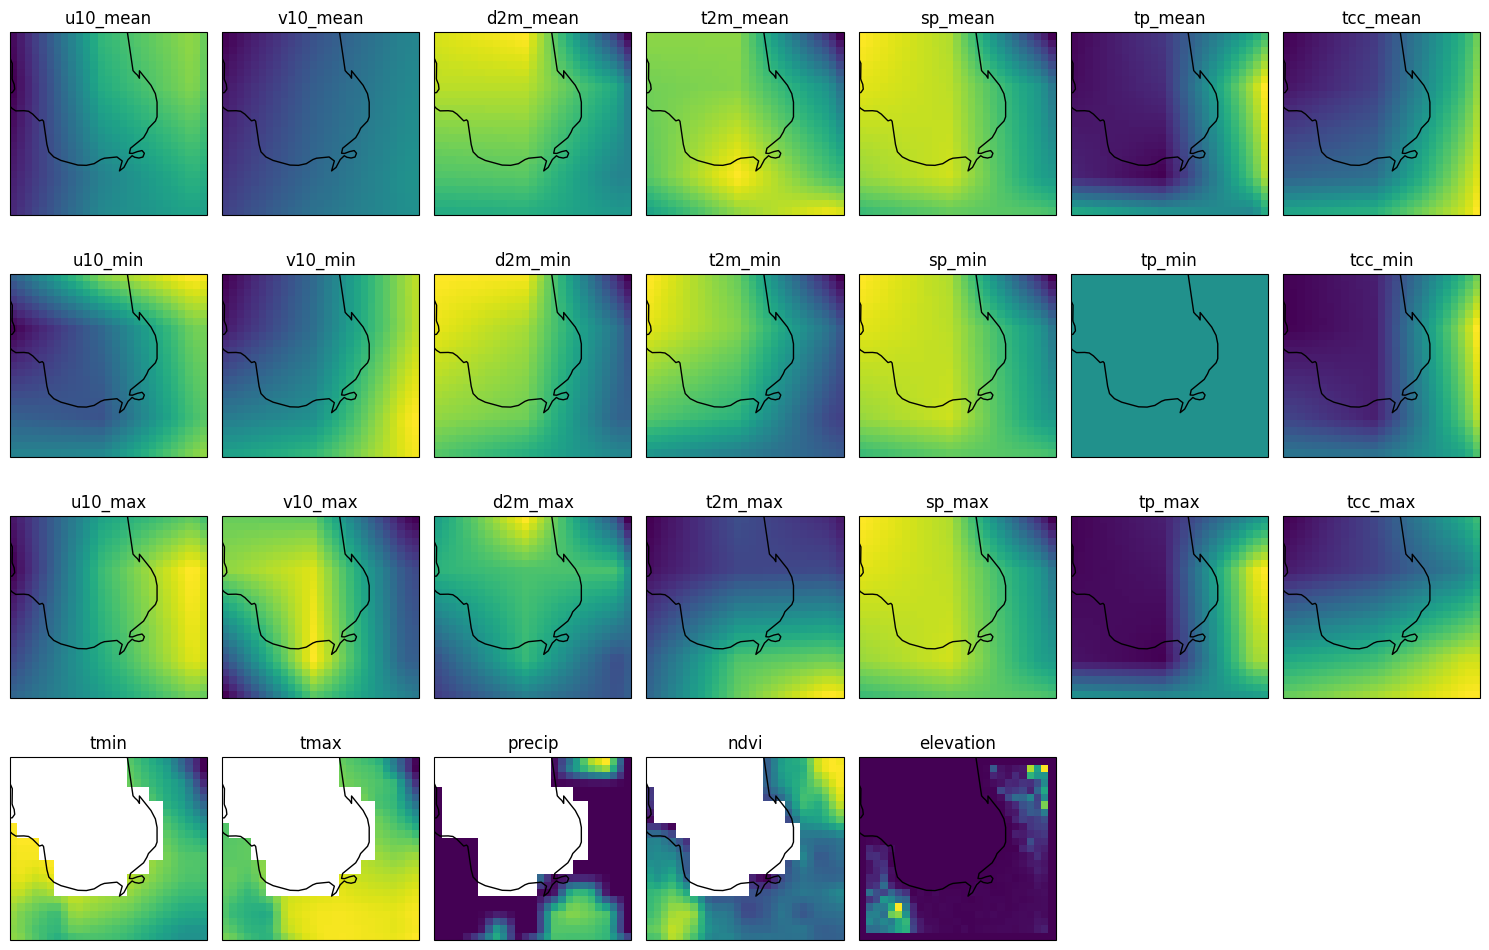

In [15]:
time_idx = 100
nrow = 4
ncol = 7

variables = [v for v in list(input_ds.variables.keys()) if v not in ['lon','lat','time','banc','spatial_ref']]
fig, axes = plt.subplots(nrow,ncol, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
for i, var_name in enumerate(variables):
    row = i // ncol
    col = i % ncol
    # Plot variable on corresponding subplot
    try:
        #data = input_ds.isel(time=time_idx)
        data = input_ds.isel(time=time_idx)
        #data = data.interpolate_na(dim="lon", method='slinear').interpolate_na(dim="lat", method='slinear')
        #mask = xr.where(data['elevation']>0,1,0)
        data = data[var_name]#/mask
        data.plot(ax=axes[row, col],
                    transform=ccrs.PlateCarree(),
                    cmap='viridis', add_colorbar=False,
                    add_labels = False, xticks=None, yticks = None)
        axes[row, col].set_title(var_name)
        axes[row, col].coastlines()
    except:
         continue

for i in range(len(variables)-1, nrow*ncol):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

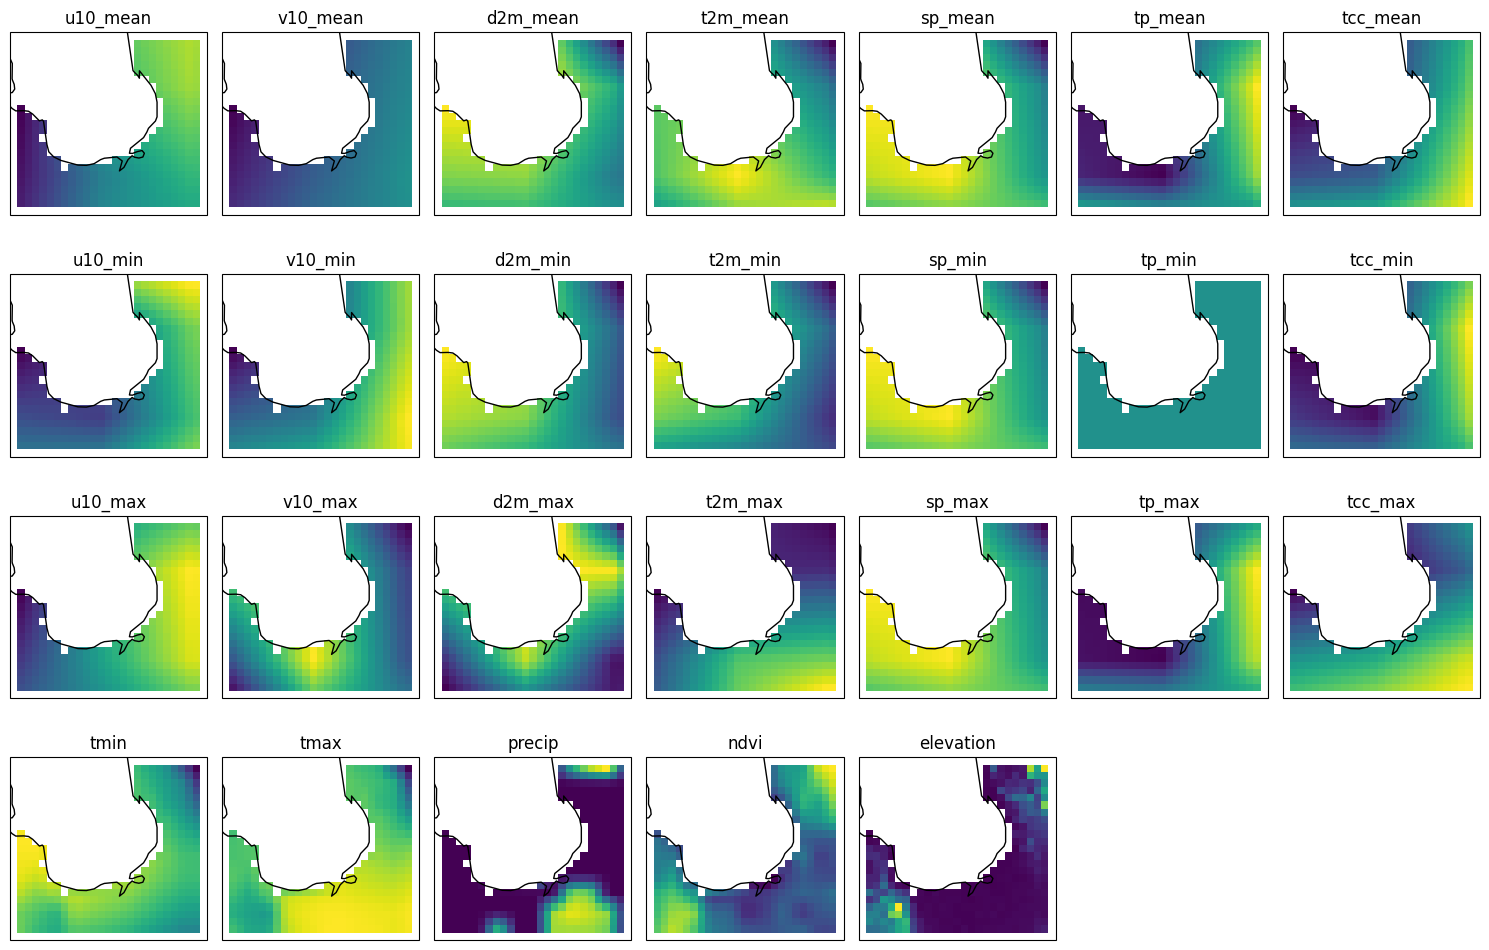

In [13]:
time_idx = 100
nrow = 4
ncol = 7

variables = [v for v in list(input_ds.variables.keys()) if v not in ['lon','lat','time','banc','spatial_ref']]
fig, axes = plt.subplots(nrow,ncol, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
for i, var_name in enumerate(variables):
    row = i // ncol
    col = i % ncol
    # Plot variable on corresponding subplot
    try:
        #data = input_ds.isel(time=time_idx)
        data = input_regridded_ds.isel(time=time_idx)
        #data = data.interpolate_na(dim="lon", method='slinear').interpolate_na(dim="lat", method='slinear')
        mask = xr.where(data['elevation']>0,1,0)
        data = data[var_name]/mask
        data.plot(ax=axes[row, col],
                    transform=ccrs.PlateCarree(),
                    cmap='viridis', add_colorbar=False,
                    add_labels = False, xticks=None, yticks = None)
        axes[row, col].set_title(var_name)
        axes[row, col].coastlines()
    except:
         continue

for i in range(len(variables)-1, nrow*ncol):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()